In [1]:
#%load_ext autoreload
#%autoreload 2
%matplotlib agg

# Opening image - image wrapper 

Library wraps:
* PIL Image 
* cv image - also focuses on RGB/BGR channel order

In [2]:
from objects.image import Image

In [3]:
# Image is copied from COCO dataset:
# http://cocodataset.org/#explore?id=96351
# http://farm4.staticflickr.com/3131/2777213612_5e5e74f24a_z.jpg

sample_image_path = './assets/sample_coco_image.jpg'

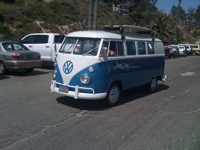

In [4]:
# From file
link_img = Image.open(sample_image_path)

# Fast preview
link_img.pp

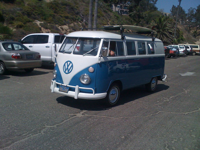

In [5]:
# From PIL image
from PIL import Image as PilImage

pil_image = PilImage.open(sample_image_path)
from_pil_img = Image.from_pil(pil_image)

# Fast preview
from_pil_img.pp

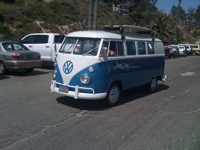

In [6]:
# From cv2 image
import cv2

cv2_image = cv2.imread(sample_image_path)
from_cv2_img = Image.from_bgr_cv2_image(cv2_image)

# Fast preview
from_cv2_img.pp

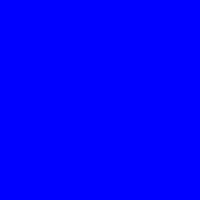

In [7]:
# From cv2 image - simulating reading as RGB (which )
import numpy as np

rgb_image = np.zeros((200,200,3), dtype='uint8')
rgb_image[:,:,2] = 255 # filling with blue
from_rgb_img = Image.from_rgb_array(rgb_image)

# Fast preview
from_rgb_img.pp

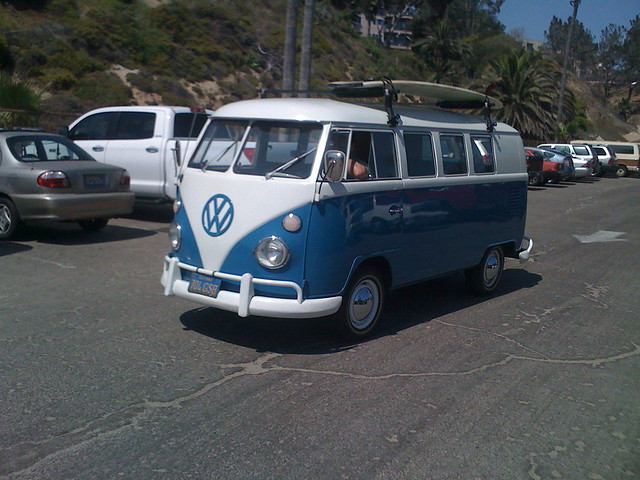

In [8]:
## Image preview - default size
sample_img = Image.open(sample_image_path)
sample_img.preview()

# Image - fast previews

In [9]:
## Image preview - any size
sample_img = Image.open(sample_image_path)
sample_img.preview(thumbnail_size = (30,30))

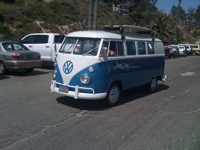

In [10]:
## Image preview - quick check (shorted code, defaults to 200x200 maximal sizes)
sample_img = Image.open(sample_image_path)
sample_img.pp

# Cropping image

Image taken from source location: (150, 90, 540, 350)


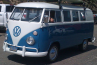

In [11]:
sample_img = Image.open(sample_image_path)
crop_img, crop_bbox = sample_img.get_crop(offset=(150,90), source_size=(390,260), target_size=(390//4,260//4))
print("Image taken from source location:", crop_bbox.to_int())
crop_img.pp

# Bounding boxes  - sample annotator

In [12]:
from samples.annotator import MaskRCNNBBoxAnnotator

In [13]:
annotator = MaskRCNNBBoxAnnotator()
sample_img = Image.open(sample_image_path)
bboxes = annotator.get_bboxes(sample_img, score_threshold=0.3, nms_threshold=0.5)

bboxes

BBox [(1.72,129.81)-(136.23,239.84) score=1.00 class=3/car] 
BBox [(524.51,147.76)-(568.86,185.52) score=0.99 class=3/car] 
BBox [(534.69,143.28)-(599.24,178.93) score=0.98 class=3/car] 
BBox [(343.59,148.83)-(370.28,179.89) score=0.94 class=1/person] 
BBox [(56.15,104.92)-(214.58,214.49) score=0.92 class=8/truck] 
BBox [(585.24,143.99)-(618.98,175.55) score=0.89 class=3/car] 
BBox [(571.51,143.74)-(599.28,177.25) score=0.83 class=3/car] 
BBox [(600.18,141.44)-(639.38,177.44) score=0.81 class=8/truck] 
BBox [(148.45,89.92)-(525.92,338.32) score=0.69 class=8/truck] 
BBox [(556.24,142.85)-(634.56,177.12) score=0.58 class=3/car] 
BBox [(538.40,146.10)-(575.09,174.12) score=0.47 class=3/car] 

# Draw bounding boxes

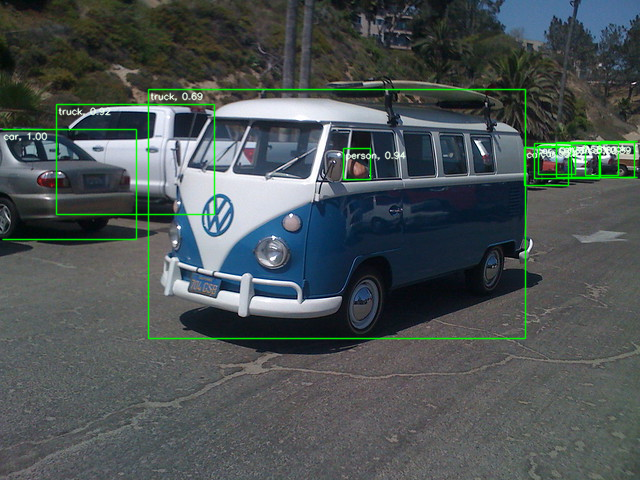

In [14]:
bboxes.draw_on(sample_img).preview()

# Bounding box - "to int" conversion

In [15]:
bbox = bboxes[0]
bbox

BBox [(1.72,129.81)-(136.23,239.84) score=1.00 class=3/car] 

In [16]:
bbox.to_int()

(1, 129, 136, 239)

# Bounding box - clipping bbox coordinates to given area (like image size)

In [17]:
bbox = bboxes[0]
bbox

BBox [(1.72,129.81)-(136.23,239.84) score=1.00 class=3/car] 

In [18]:
bbox.clip(0,0,100,100)
bbox

BBox [(1.72,100.00)-(100.00,100.00) score=1.00 class=3/car] 

In [19]:
bbox.to_int()

(1, 100, 100, 100)

# Video annotation

In [20]:
from base.video_annotator import VideoAnnotator

In [21]:
va = VideoAnnotator(annotator)

### maxframes parameters adds option for quick checks in experiments

In [22]:
vann = va.annotate('./assets/cars.mp4', cache_file_path='./assets/cache_cars.pkl', maxframes=300)

In [23]:
vann

BBoxListFrames with 300 frames with average of 17.54 bbox(es) per frame.

# Reduce classes list

In [24]:
vann.reduce_to_classes(['car'])
vann

BBoxListFrames with 300 frames with average of 16.43 bbox(es) per frame.

# Rendering bounding boxes on the video and saving

In [25]:
va.render('./assets/cars.mp4', vann, "./assets/result_cars.mp4")

Rendering video: 100%|█████████▉| 299/300 [00:05<00:00, 54.69it/s]


# Objects heatmap

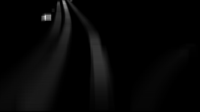

In [26]:
va.get_bbox_heatmap('./assets/cars.mp4', vann).pp

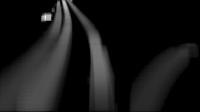

In [27]:
va.get_bbox_heatmap('./assets/cars.mp4', vann, use_sqrt=True).pp

# Tracking number of objects - plot with mean average

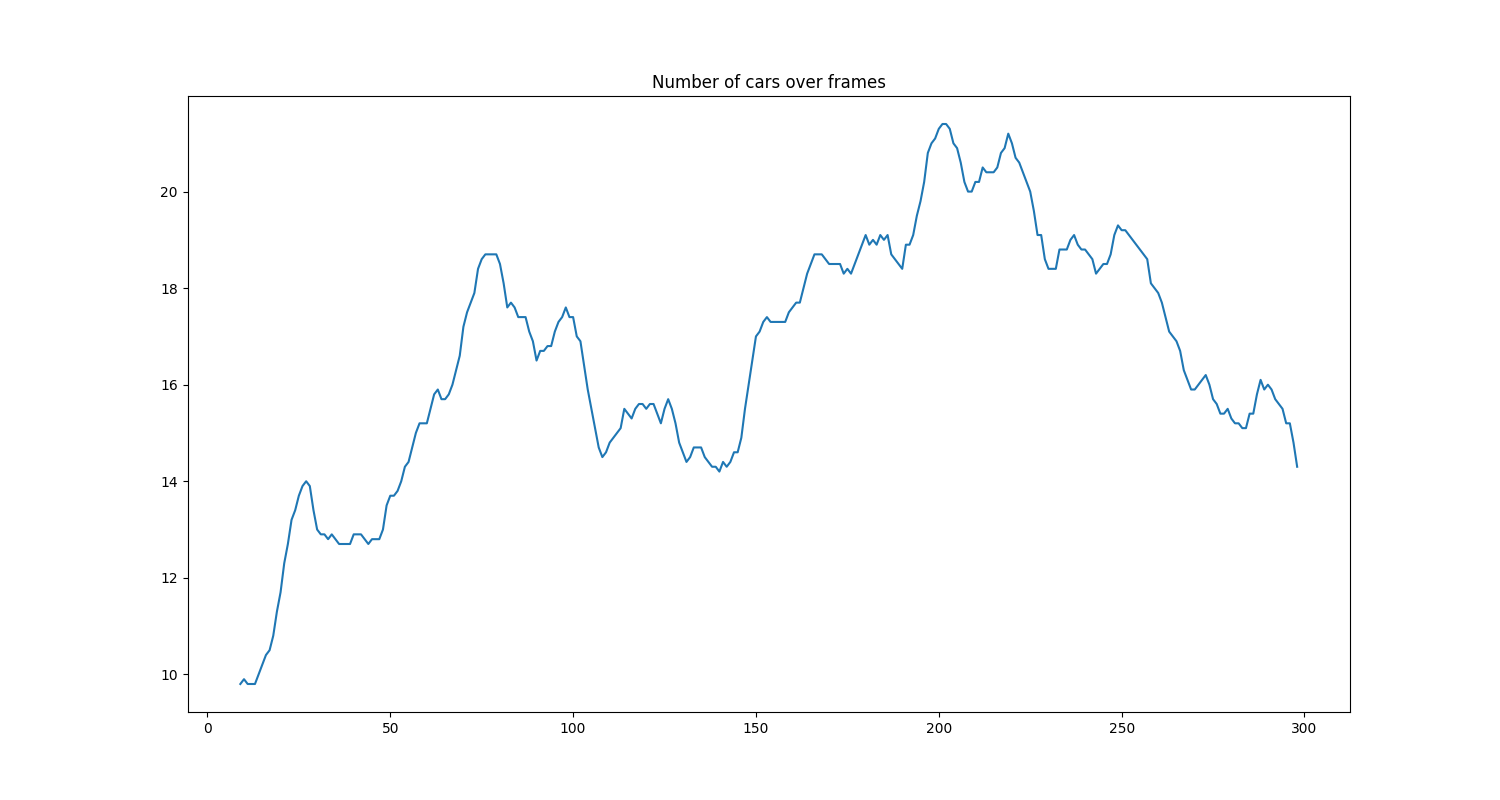

In [28]:
count_plot = va.get_count_plot(vann, moving_avg=10, title="Number of cars over frames")
count_plot.preview()

# Tracking number of objects - bar plot with grouping 

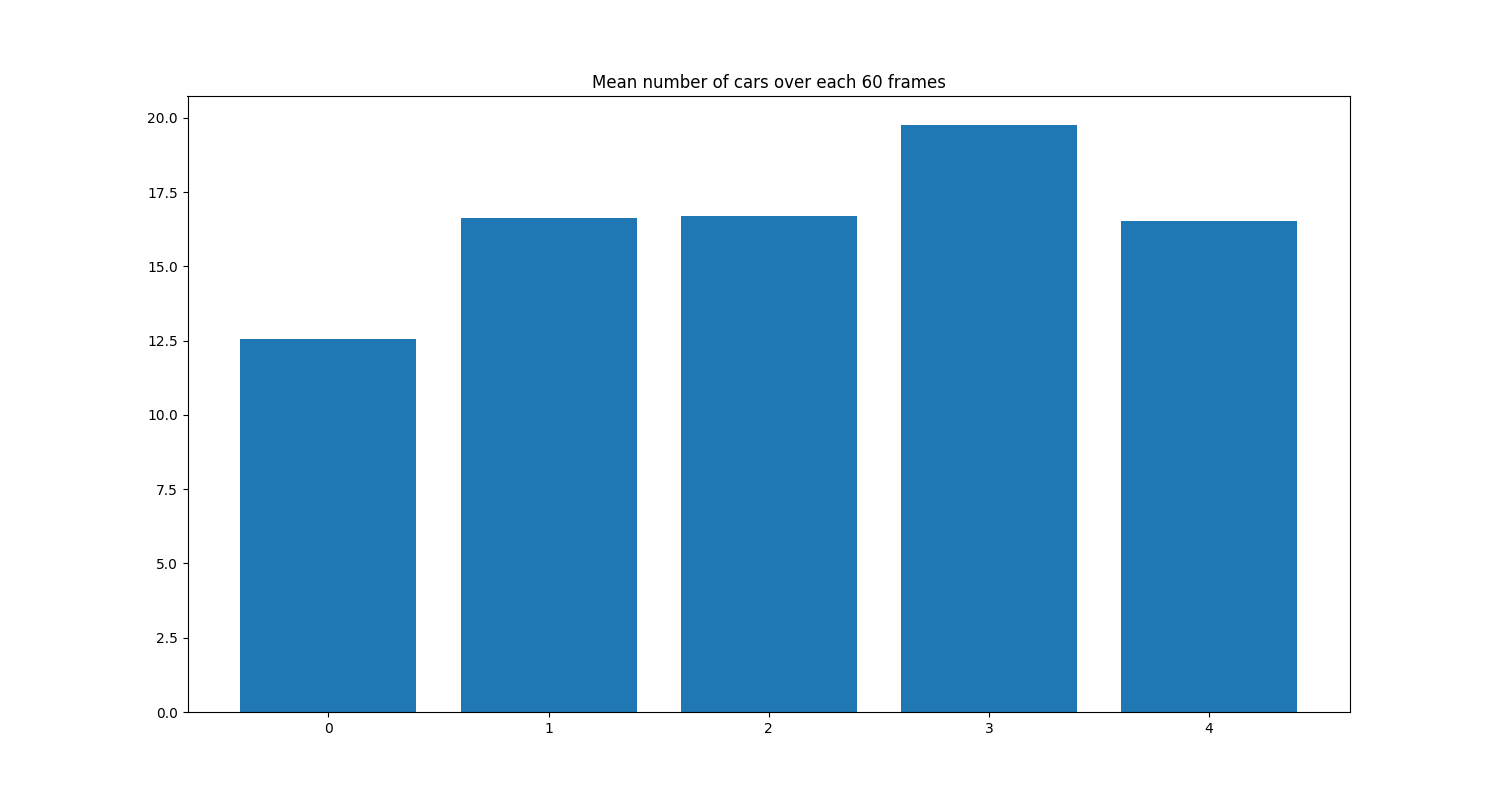

In [29]:
bar_count_plot = va.get_bar_count_plot(vann, bin_count=60, title="Mean number of cars over each 60 frames")
bar_count_plot.preview()

# Bounging boxes tracking and groupping

In [30]:
from base.groupping import BBoxGroupping

# Track bboxes between frames
bbg = BBoxGroupping(vann)
iou_threshold=0.7
fill_missing_frames=3
known_bboxes = bbg.group(iou_threshold=iou_threshold, fill_missing_frames=fill_missing_frames)

# Rendering bboxes with groupped bounging boxes
va.render('./assets/cars.mp4', vann, 
          f"./assets/result_cars_groups_{iou_threshold}_{fill_missing_frames}.mp4", 
          known_bboxes = known_bboxes,
          history_length=30)

Groupping:   0%|          | 0/300 [00:00<?, ?it/s]/home/bmatuszewki/Projects/annovid/objects/bbox.py:51: RuntimeWarning: divide by zero encountered in true_divide
  iou = intersection_area / float(area1 + area2 - intersection_area)
Rendering video:  99%|█████████▉| 298/300 [00:06<00:00, 47.11it/s]
